In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import autokeras as ak
import os 
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow import keras

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
from sklearn.utils import shuffle
import time
%config InlineBackend. figure_format = 'retina'

# Install TensorFlow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers

from sklearn.metrics import confusion_matrix
import tensorflow.keras.backend as K
from sklearn import metrics

from tensorflow.python.client import device_lib

In [3]:
data = np.load('/work/n1000000_0804_all_flat.npz')
cut_index = np.load('/work/NIO_largerthan1000_index.npy')

In [4]:
input_state = 2

target = data['delta']
if input_state == 0:
    data_all = data['ve_dune']
elif input_state == 1:
    data_all = np.column_stack([data['ve_dune'], data['vu_dune'], data['vebar_dune'], data['vubar_dune']])
elif input_state == 2:
    data_all = np.column_stack([data['ve_dune'], data['vu_dune'], data['vebar_dune'], data['vubar_dune'], data['ve_t2hk'], data['vu_t2hk'], data['vebar_t2hk'], data['vubar_t2hk']])

x_train = data_all[:10000, cut_index]
y_train = target[:10000]/360
x_train2 = data_all[10000:900000, cut_index]
y_train2 = target[10000:900000]/360
x_test = data_all[900000:, cut_index]
y_test = target[900000:]/360

In [5]:
generate = 10
num_of_bins = len(x_train[0])
scale = 0.001

x_train_gen = np.reshape(np.random.normal(x_train, np.sqrt(x_train)*scale, size = (generate, len(x_train), num_of_bins)), (generate*len(x_train), num_of_bins))
y_train_gen = np.repeat(y_train, generate)
x_train2_gen = np.reshape(np.random.normal(x_train2, np.sqrt(x_train2)*scale, size = (generate, len(x_train2), num_of_bins)), (generate*len(x_train2), num_of_bins))
y_train2_gen = np.repeat(y_train2, generate)
x_test_gen = np.reshape(np.random.normal(x_test, np.sqrt(x_test)*scale, size = (generate, len(x_test), num_of_bins)), (generate*len(x_test), num_of_bins))
y_test_gen = np.repeat(y_test, generate)

In [23]:
train_mode = 0
if train_mode == 0:
    input_shape = (num_of_bins,)
    model = Sequential(name = 'Sequential')
    model.add(BatchNormalization(input_shape=input_shape, name = 'BatchNormalization'))
    model.add(Dense(32, activation='relu', name = 'dense_1'))
    model.add(Dense(128, activation='relu', name = 'dense_2'))
    model.add(Dense(1, activation='sigmoid', name = 'deltacp'))
    model_opt = keras.optimizers.Adadelta()
    model.compile(loss="mean_squared_error",
                       optimizer=model_opt,
                       metrics=["mse"])
    model.summary()
#     History = model.fit(x_train_gen, y_train_gen,
#                validation_split = 0.1,
#                batch_size=512,
#                epochs=2,
#                verbose=1
#               )
elif train_mode == 1:
    clf.fit(x_train_gen, y_train_gen,
           validation_split = 0.1,
           batch_size=64,
           epochs=2,
           verbose=1,
           shuffle = True
       )
    model = clf.export_model()
    model.summary()

Model: "Sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
BatchNormalization (BatchNor (None, 17)                68        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                576       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4224      
_________________________________________________________________
deltacp (Dense)              (None, 1)                 129       
Total params: 4,997
Trainable params: 4,963
Non-trainable params: 34
_________________________________________________________________


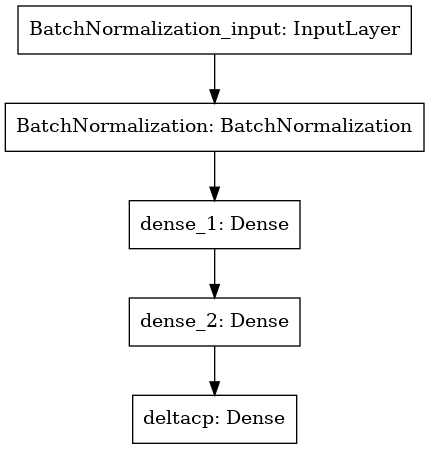

In [24]:
plot_model(model, 'deltacp.png')

In [16]:
model.fit(x_train2_gen, y_train2_gen,
           validation_split = 0.1,
           batch_size=64,
           epochs=5,
           verbose=1,
           shuffle = True
         )

Epoch 1/5
125157/125157 [==============================] - 256s 2ms/step - loss: 0.0834 - mse: 0.0834 - val_loss: 0.0832 - val_mse: 0.0832
Epoch 2/5
125157/125157 [==============================] - 256s 2ms/step - loss: 0.0833 - mse: 0.0833 - val_loss: 0.0832 - val_mse: 0.0832
Epoch 3/5
125157/125157 [==============================] - 254s 2ms/step - loss: 0.0833 - mse: 0.0833 - val_loss: 0.0832 - val_mse: 0.0832
Epoch 4/5
125157/125157 [==============================] - 243s 2ms/step - loss: 0.0833 - mse: 0.0833 - val_loss: 0.0832 - val_mse: 0.0832
Epoch 5/5
125157/125157 [==============================] - 250s 2ms/step - loss: 0.0833 - mse: 0.0833 - val_loss: 0.0832 - val_mse: 0.0832


In [17]:
model.evaluate(x_test_gen, y_test_gen)
pre_test = model.predict(x_test_gen)

31250/31250 [==============================] - 47s 2ms/step - loss: 0.0829 - mse: 0.0829


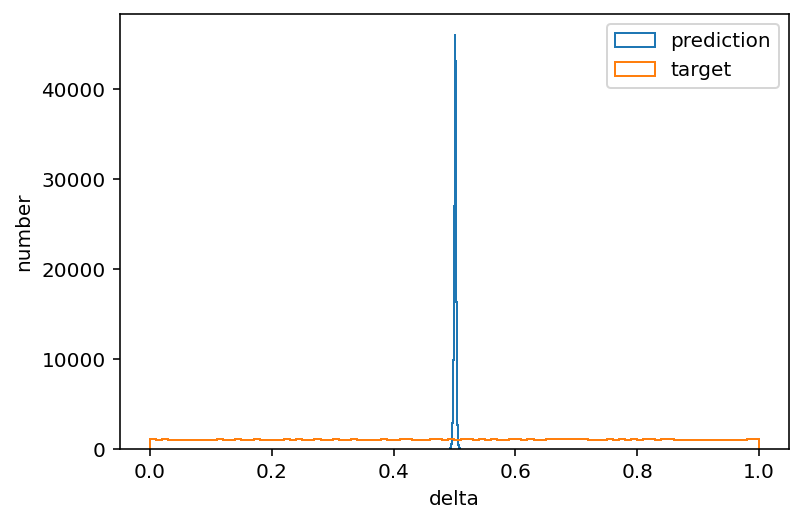

In [18]:
plt.hist(pre_test[:, 0], histtype = 'step', bins = 100, label = 'prediction')
plt.hist(y_test, histtype = 'step', bins = 100, label = 'target')
plt.xlabel('delta')
plt.ylabel('number')
plt.legend()
plt.show()

Text(0.5, 1.0, 'delta')

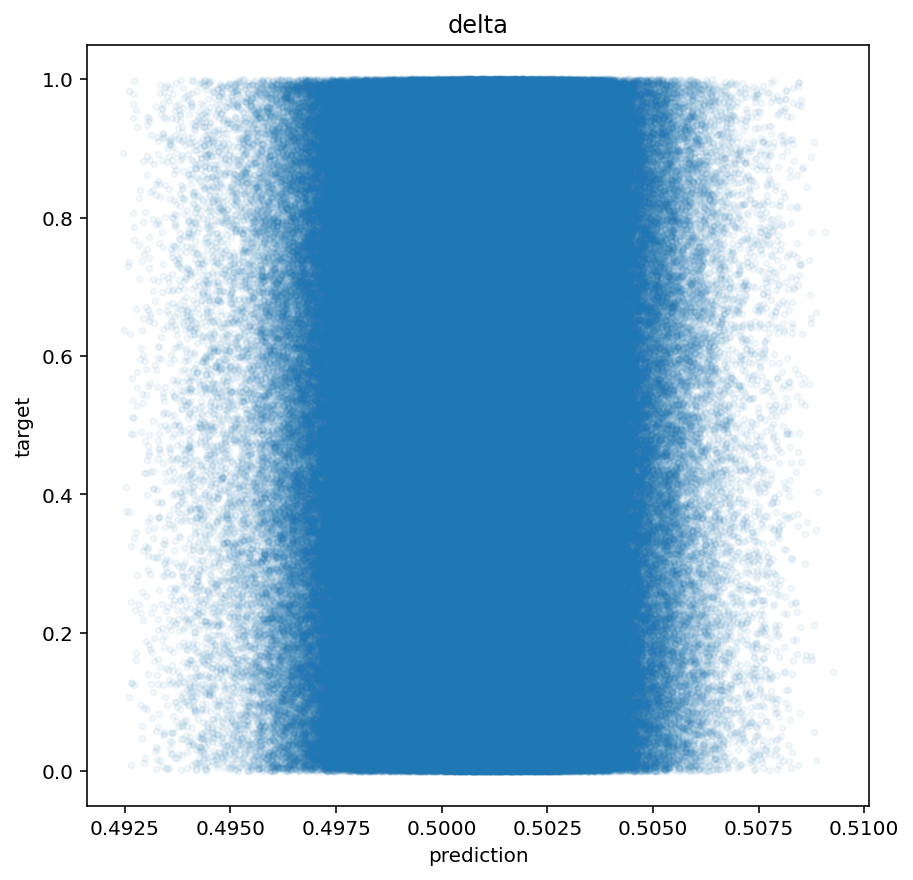

In [19]:
plt.figure(figsize=(7,7))
plt.plot(pre_test[:, 0], y_test_gen, '.', alpha = 0.05)
plt.xlabel('prediction')
plt.ylabel('target')
plt.title('delta')

In [ ]:
if input_state == 0:
    modelname = '/work/Regression/models_ve_dune/0803_delta4.h5'
    if not os.path.isfile(modelname):
        model.save(modelname)
elif input_state == 1:
    modelname = '/work/Regression/models_all_dune/0803_delta2.h5'
    if not os.path.isfile(modelname):
        model.save(modelname)
elif input_state == 2:
    modelname = '/work/Regression/models_all/0804_delta2.h5'
    if not os.path.isfile(modelname):
        model.save(modelname)

In [16]:
if input_state == 0:
    modelname = '/work/Regression/models_ve_dune/0803_delta1.h5'
    if not os.path.isfile(modelname):
        model.save(modelname)
elif input_state == 1:
    modelname = '/work/Regression/models_all_dune/0803_delta1.h5'
    if not os.path.isfile(modelname):
        model.save(modelname)
elif input_state == 2:
    modelname = '/work/ML4NO/ML/Regression/perturb_cut/0804_cut1000_delta1.h5'
    if not os.path.isfile(modelname):
        model.save(modelname)